In [1]:
import utils
import prepare_datasets_for_ML as preparation

import os
import numpy as np
import skimage
import cv2
import pandas as pd
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
import segmentation_models as sm

from skimage.filters import frangi
from skimage.morphology import remove_small_objects, binary_dilation, binary_erosion
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from tensorflow import keras

sm.set_framework('tf.keras')
sm.framework()

np.random.seed(42)

Segmentation Models: using `keras` framework.


In [2]:
from ipynb.fs.defs.Image_Processing import detect_blood_vessels_using_image_processing
from ipynb.fs.defs.Machine_Learning import preprocess_image_for_ML, process_predicted_image
from ipynb.fs.defs.Keras_Deep_Learning import Dataset, Dataloader, round_clip_0_1, get_training_augmentation, get_validation_augmentation, get_preprocessing

In [3]:
X_images, y_images = utils.load_all_images()
X_images, X_masks = zip(*X_images)

X_test = X_images[-6:]
y_test = y_images[-6:]
masks_test = X_masks[-6:]

Loading sets ('dr', 'g', 'h') of images: 100%|█████████████████████████████████████████| 15/15 [00:12<00:00,  1.19it/s]


# Setup models

In [4]:
curr_dir_path = os.path.abspath('')
model_dir_path = os.path.join(curr_dir_path, "models")

In [5]:
xgb_model_path = os.path.join(model_dir_path, "xgb_optuna_model.sav")

xgb_clf = pickle.load(open(xgb_model_path, 'rb'))

In [6]:
n_classes = 1 
activation = 'sigmoid'
BACKBONE = 'efficientnetb3'

unet_model_path = os.path.join(model_dir_path, "best_model_unet.h5")

preprocess_input = sm.get_preprocessing(BACKBONE)
unet_model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
unet_model.load_weights(unet_model_path) 

In [7]:
test_dataset = Dataset(
    X_test, 
    y_test, 
    classes=["blood_vessel"], 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

# Visualize results

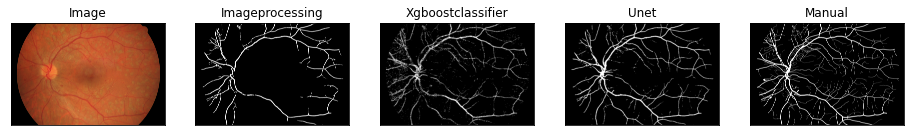

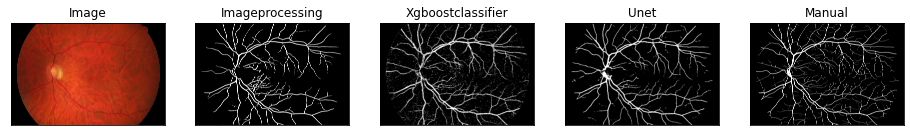

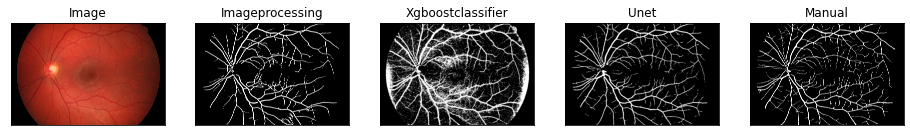

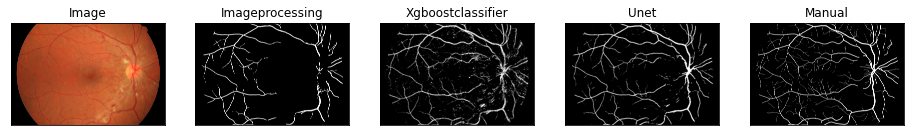

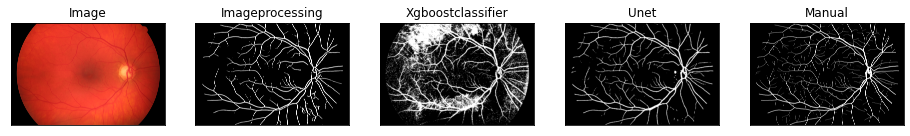

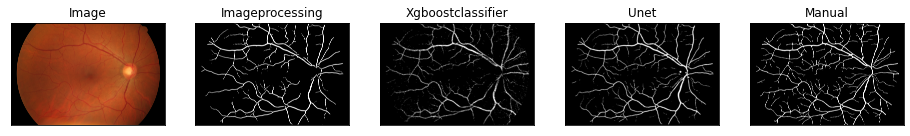

In [8]:
for i, (image, mask, manual) in enumerate(zip(X_test, masks_test, y_test)):
    IP_result = detect_blood_vessels_using_image_processing(image, mask)
    
    df, new_mask = preprocess_image_for_ML(image, mask, manual, 5, 5)
    ML_result = xgb_clf.predict(df[df.columns.difference(['label'])])
    width, height, _ = image.shape
    ML_result = process_predicted_image(ML_result, new_mask, width//5, height//5)
    
    KDL_image, _ = test_dataset[i]
    KDL_image = np.expand_dims(KDL_image, axis=0)
    KDL_result = 1 - unet_model.predict(KDL_image).round().squeeze()
    
    utils.visualize(
        image=image,
        ImageProcessing=IP_result,
        XGBoostClassifier=ML_result,
        Unet=KDL_result,
        manual=manual)
 
    